In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and combine data
data_path = os.walk('DMS3003_Proj_Data')

file_count = 0
for path, dir_list, file_list in data_path:  
    for files in file_list:
        name_split = files[:-5].split('_')
        if file_count == 0:
            combined_data = pd.read_csv('DMS3003_Proj_Data/' + files, index_col=0)
            combined_data['city'] = name_split[0]
            combined_data['is_weekend'] = (name_split[1] == 'weekend')
            file_count += 1
        else:
            next_data = pd.read_csv('DMS3003_Proj_Data/' + files, index_col=0)
            next_data['city'] = name_split[0]
            next_data['is_weekend'] = (name_split[1] == 'weekend')
            combined_data = pd.concat([combined_data, next_data])

combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51707 entries, 0 to 1798
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  bool   
 3   room_private                51707 non-null  bool   
 4   person_capacity             51707 non-null  float64
 5   host_is_superhost           51707 non-null  bool   
 6   multi                       51707 non-null  int64  
 7   biz                         51707 non-null  int64  
 8   cleanliness_rating          51707 non-null  float64
 9   guest_satisfaction_overall  51707 non-null  float64
 10  bedrooms                    51707 non-null  int64  
 11  dist                        51707 non-null  float64
 12  metro_dist                  51707 non-null  float64
 13  attr_index                  5170

In [3]:
# Data cleaning
raw_data = combined_data[['realSum', 'room_type', 'person_capacity', 'host_is_superhost', 
                          'multi', 'biz', 'cleanliness_rating', 
                          'guest_satisfaction_overall', 'bedrooms', 'dist', 
                          'metro_dist', 'city', 'is_weekend'
                          ]
                         ]

binaried_data = pd.get_dummies(raw_data, columns=['room_type'], drop_first=True)
binaried_data.rename(columns={'room_type_Private room':'room_type_Private', 
                              'room_type_Shared room':'room_type_Shared'
                              }, inplace=True)
binaried_data.reset_index(inplace=True, drop=True)
binaried_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     51707 non-null  float64
 1   person_capacity             51707 non-null  float64
 2   host_is_superhost           51707 non-null  bool   
 3   multi                       51707 non-null  int64  
 4   biz                         51707 non-null  int64  
 5   cleanliness_rating          51707 non-null  float64
 6   guest_satisfaction_overall  51707 non-null  float64
 7   bedrooms                    51707 non-null  int64  
 8   dist                        51707 non-null  float64
 9   metro_dist                  51707 non-null  float64
 10  city                        51707 non-null  object 
 11  is_weekend                  51707 non-null  bool   
 12  room_type_Private           51707 non-null  uint8  
 13  room_type_Shared            517

In [28]:
netherland = raw_data.groupby('city').get_group('amsterdam')['room_type']
netherland.value_counts()['Entire home/apt'] / len(netherland)

0.5413461538461538

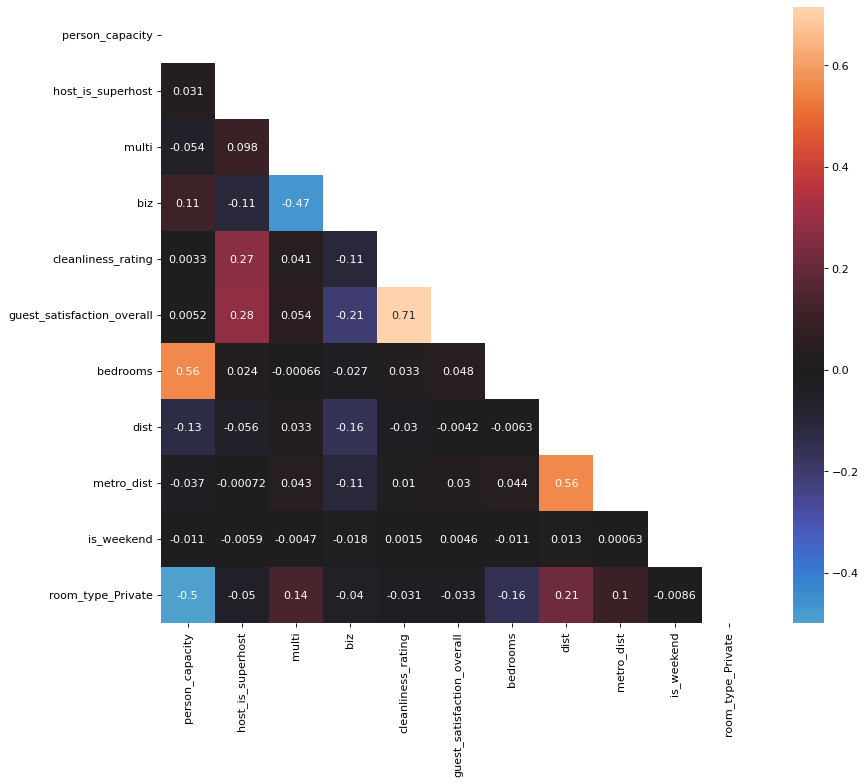

In [19]:
factors = binaried_data.iloc[:, 1:-1]
mask = np.zeros_like(factors.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12,10), dpi=80)
sns.heatmap(
    factors.corr(), 
    mask=mask, 
    xticklabels=factors.corr().columns, 
    yticklabels=factors.corr().columns, 
    center=0, 
    annot=True
)
plt.show()

In [4]:
# Data structure visualization
from plottable import Table, ColDef

target_vars = ['realSum', 'person_capacity', 'cleanliness_rating', 
               'guest_satisfaction_overall', 'bedrooms', 
               'dist', 'metro_dist', 'city']
target_data = binaried_data[target_vars]
depart = target_data.groupby('city')
cities = target_data['city'].unique()

comb = []
for c in cities:
    target = depart.get_group(c)
    target_mean = round(target.mean(), 2)
    target_sd = round(target.std(), 2)
    target_df = pd.concat([target_mean, target_sd], axis=1)
    comb.append(target_df)

show_df = pd.concat(comb, axis=1)
first_lv_col = cities.tolist()*2
first_lv_col.sort()
second_lv_col = ['Avg', 'Std']*len(cities)
show_df.columns = [first_lv_col, second_lv_col]
show_df.to_excel('show.xlsx')

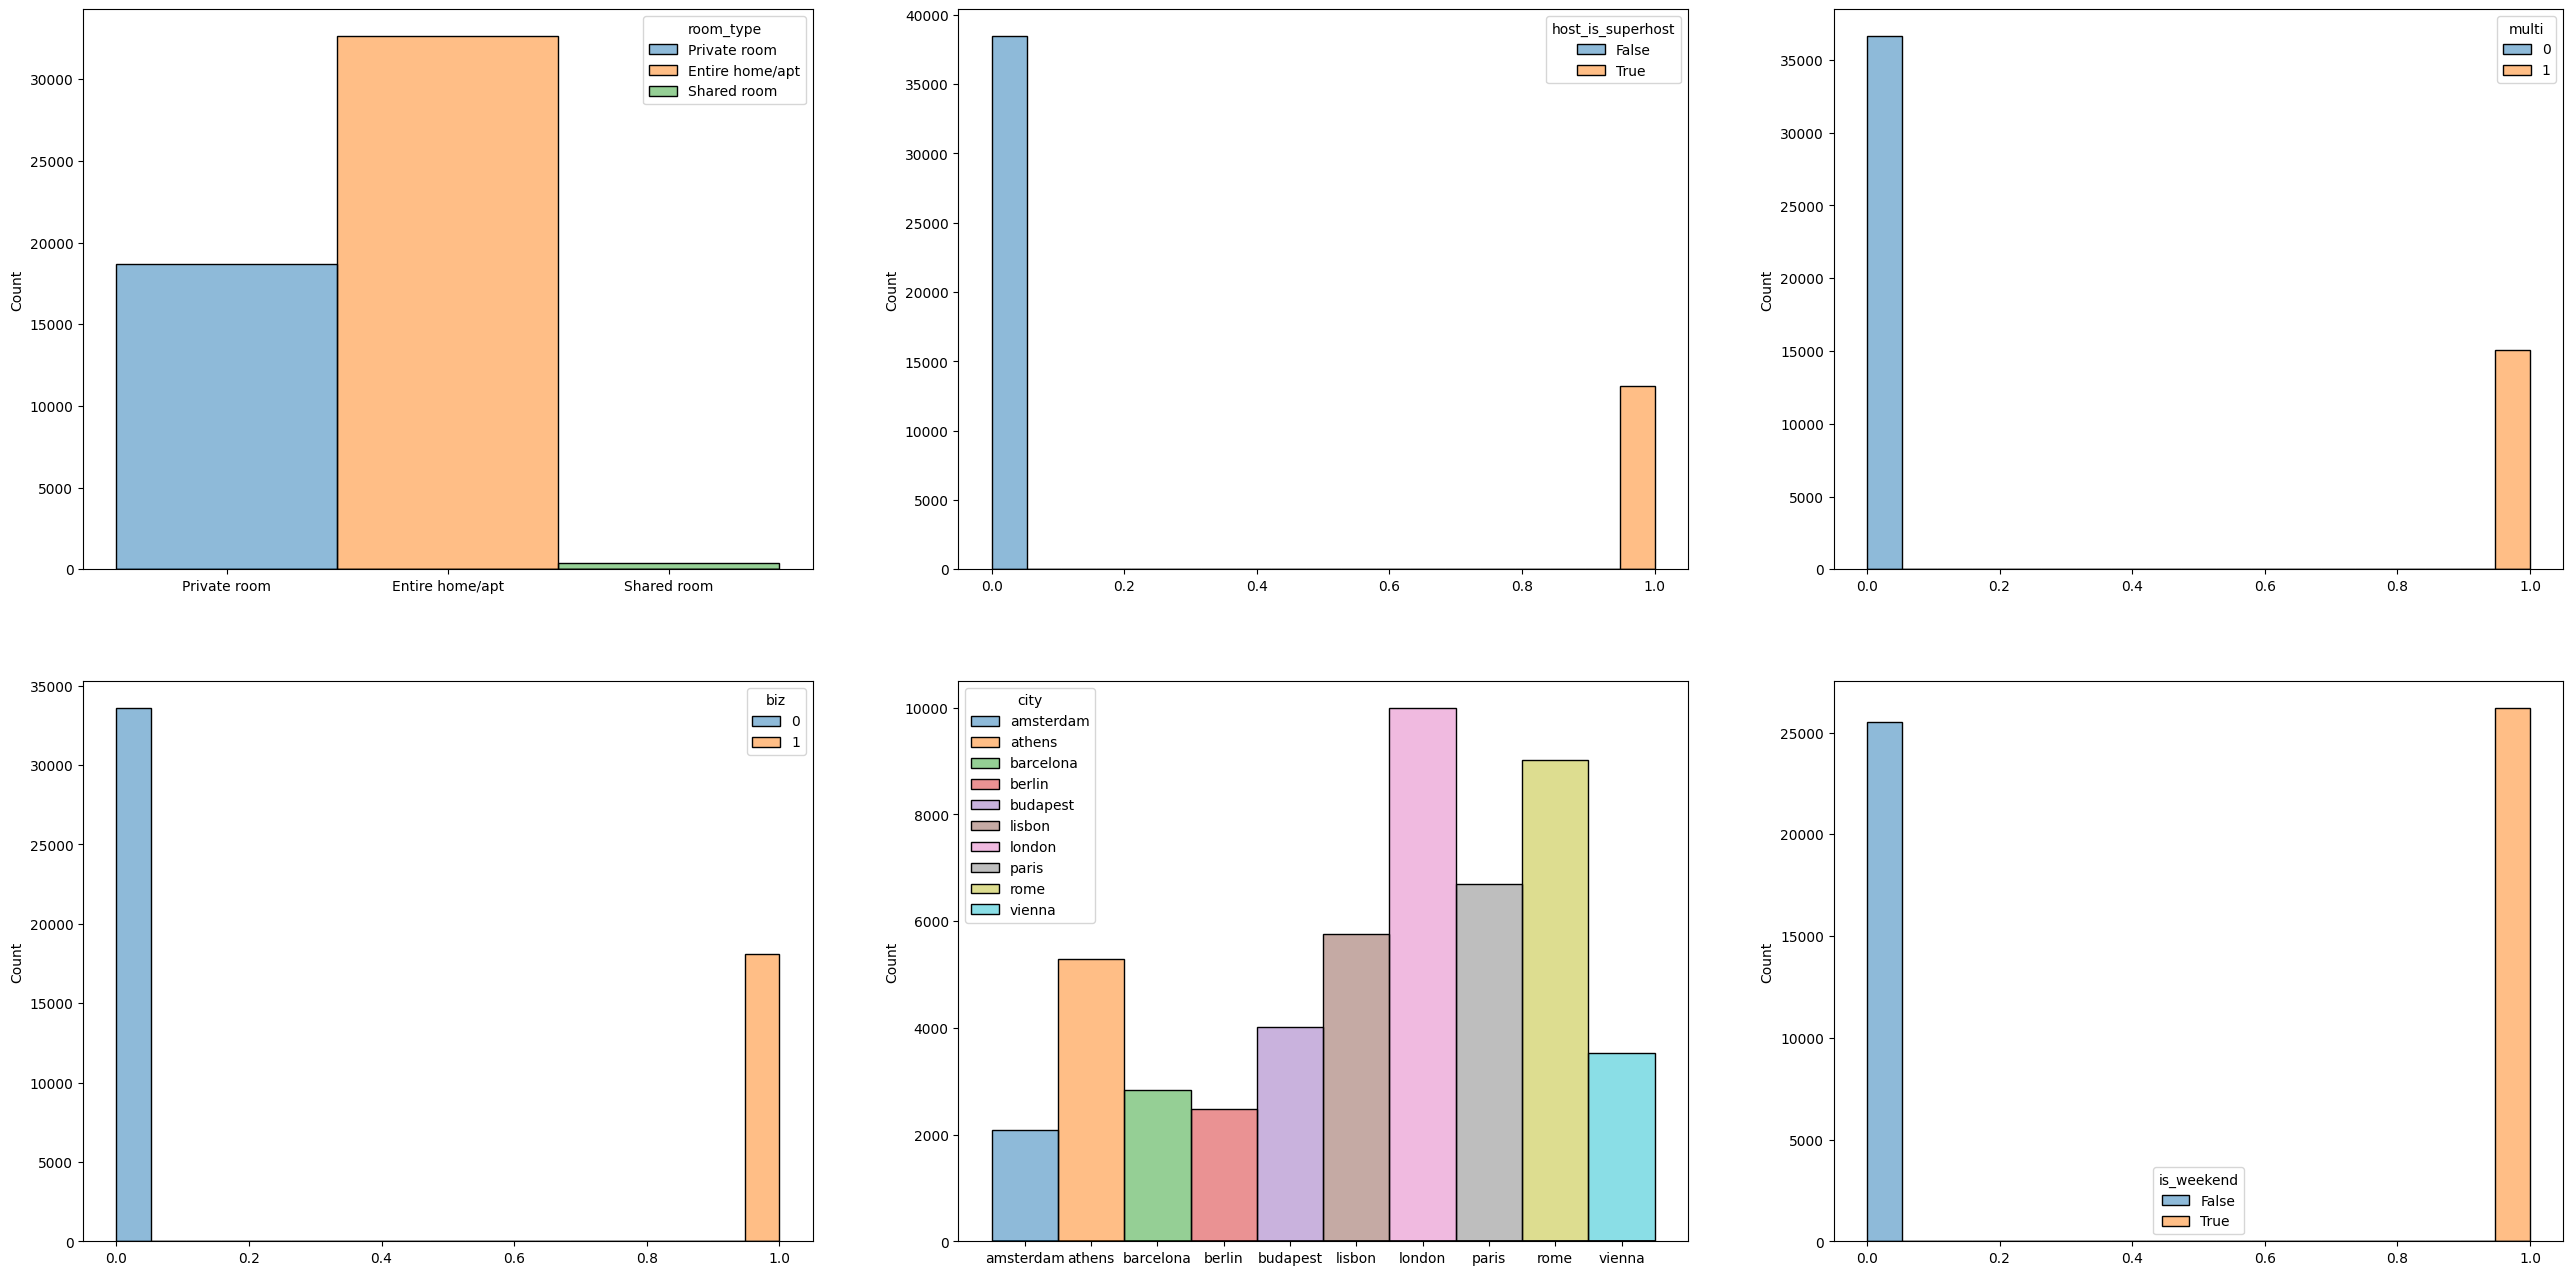

In [5]:
# Data structure visualization

data_info = pd.concat([raw_data.dtypes.astype(str), raw_data.nunique()], axis=1)
data_info.rename(columns={0:'dtype', 1:'nunique'}, inplace=True)
cate_vars = data_info.query('dtype=="object" or nunique==2').index.tolist() # Discover categorical features
var_count = len(cate_vars)

fig, axis = plt.subplots((var_count+2)//3, 3, figsize=(32, 16)) # nx3 grid of subplots
for i in range((var_count+2)//3):
    sns.histplot(ax=axis[i,0], data=raw_data, x=cate_vars[i*3], hue=cate_vars[i*3]).set(xlabel=None)
    try:
        sns.histplot(ax=axis[i,1], data=raw_data, x=cate_vars[i*3+1], hue=cate_vars[i*3+1]).set(xlabel=None)
    except:
        plt.delaxes(axis[i,1])
    try:
        sns.histplot(ax=axis[i,2], data=raw_data, x=cate_vars[i*3+2], hue=cate_vars[i*3+2]).set(xlabel=None)
    except:
        plt.delaxes(axis[i,2])

In [6]:
def detect_outlier(var):
    # Calculate descriptive statistics of the variable
    stats = var.describe()
    # Compute the Interquartile Range (IQR) which is the difference between the 75th and 25th percentiles
    iqr = stats["75%"] - stats["25%"]
    # Determine the upper and lower limit for outliers 
    upper_limit = stats["75%"] + 1.5 * iqr
    lower_limit = stats["25%"] - 1.5 * iqr

    # Store the upper and lower limits in a variable
    para = (upper_limit, lower_limit)  
    print(f"for {var.name}: the upper and lower limits for non-outliers are {round(upper_limit, 2)} and {round(lower_limit, 2)}, with an IQR of {round(iqr, 2)}")
    
    #calculate number of outliers detected
    tmp = pd.concat([var > upper_limit, var < lower_limit], axis=1)
    # Any row in 'tmp' that has True in either column is considered an outlier
    outlier_index = tmp.any(axis=1)
    try:
        outlier_count = outlier_index.value_counts()[1]
    except:
        outlier_count = 0

    print("Num of outlier detected:", outlier_count)
    print("Proportion of outlier detected", outlier_count/len(outlier_index))
    print("\n")
    return outlier_index, para

In [7]:
city_combine = []
for c in cities:
    pool = binaried_data.groupby('city').get_group(c)['realSum']
    outlier_index, para = detect_outlier(pool)
    yes_index = []
    for j in range(len(outlier_index)):
        if outlier_index.iloc[j]:
            yes_index.append(outlier_index.index[j])

    pool.drop(labels=yes_index, inplace=True)
    labelled_pool = pd.concat([pool, pd.DataFrame([c]*len(pool), index=pool.index, columns=['city'])], axis=1)
    
    city_combine.append(labelled_pool)

boxplot_set = pd.concat(city_combine, axis=0)
boxplot_set

for realSum: the upper and lower limits for non-outliers are 1218.36 and -200.1, with an IQR of 354.62
Num of outlier detected: 105
Proportion of outlier detected 0.05048076923076923


for realSum: the upper and lower limits for non-outliers are 280.86 and -10.66, with an IQR of 72.88
Num of outlier detected: 293
Proportion of outlier detected 0.055492424242424246


for realSum: the upper and lower limits for non-outliers are 583.24 and -92.63, with an IQR of 168.97
Num of outlier detected: 227
Proportion of outlier detected 0.0801270737733851


for realSum: the upper and lower limits for non-outliers are 478.52 and -55.27, with an IQR of 133.45
Num of outlier detected: 165
Proportion of outlier detected 0.06642512077294686


for realSum: the upper and lower limits for non-outliers are 307.96 and 15.63, with an IQR of 73.08
Num of outlier detected: 223
Proportion of outlier detected 0.055445052212829436


for realSum: the upper and lower limits for non-outliers are 475.61 and -29.08, w

,realSum,city
0,194.033698,amsterdam
1,344.245776,amsterdam
2,264.101422,amsterdam
3,433.529398,amsterdam
4,485.552926,amsterdam
...,...,...
51696,359.021107,vienna
51700,115.933899,vienna
51703,304.793960,vienna
51705,301.054157,vienna


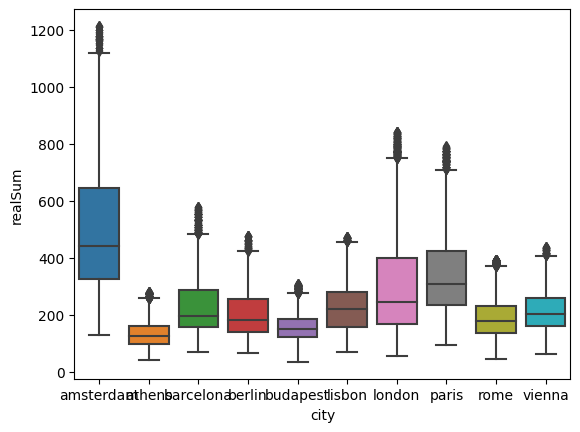

In [8]:
sns.boxplot(x=boxplot_set['city'], y=boxplot_set['realSum'])
plt.show()

In [9]:
# City comparison
count = 0
for c in binaried_data['city'].unique():
    subset = binaried_data.query(f'city == "{c}"')['realSum']
    sub_mean = subset.mean()
    sub_sd = subset.std()
    if count == 0:
        dep_var_comparison = pd.DataFrame({'city':c, 'mean':sub_mean, 'std':sub_sd}, index=[0])
    else:
        dep_var_comparison = dep_var_comparison.append(
            pd.DataFrame({'city':c, 'mean':sub_mean, 'std':sub_sd}, index=[0]), 
            ignore_index=True
        )
    count += 1

dep_var_comparison

,city,mean,std
0,amsterdam,573.112795,430.658406
1,athens,151.744121,265.880053
2,barcelona,293.753706,355.467888
3,berlin,244.583752,235.329289
4,budapest,176.513548,131.144806
5,lisbon,238.210479,108.973079
6,london,362.469256,471.357265
7,paris,392.531403,330.949745
8,rome,205.391950,118.618103
9,vienna,241.582484,397.747165


In [22]:
# Linear regression
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats import diagnostic as dia
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.tools.tools import add_constant

group = binaried_data.loc[boxplot_set.index, :].groupby('city')

vif_series = []
for c in cities:
    this_city = group.get_group(c)
    vif_test_var = add_constant(
        this_city[
            ['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist']
        ]
    )
    vif = [VIF(vif_test_var, i) for i in range(vif_test_var.shape[1])]
    vif_series.append(vif[1:])

    ols_model = sm.ols(
        formula='realSum ~ person_capacity + host_is_superhost + multi + biz + cleanliness_rating \
        + guest_satisfaction_overall + bedrooms + dist + metro_dist + is_weekend + room_type_Private', 
        data=this_city
    ).fit()
    this_city['loge2'] = np.log(ols_model.resid**2)
    loge2_model = sm.ols(
        formula='loge2 ~ person_capacity + host_is_superhost + multi + biz + cleanliness_rating \
        + guest_satisfaction_overall + bedrooms + dist + metro_dist + is_weekend + room_type_Private', 
        data=this_city
    ).fit()
    wls_weight = list(1 / np.exp(loge2_model.fittedvalues))
    fwls_model = sm.wls(
        formula='realSum ~ person_capacity + host_is_superhost + multi + biz + cleanliness_rating \
        + guest_satisfaction_overall + bedrooms + dist + metro_dist + is_weekend + room_type_Private', 
        data=this_city, 
        weights=wls_weight
    ).fit()

    print(f'Regression result of city {c}: ')
    het = dia.het_breuschpagan(ols_model.resid, ols_model.model.exog)
    print('Hetero P-value: ', het[-1])
    print(ols_model.summary(), '\n')
'''
plt.figure()
model.resid.plot.density()
plt.show()
'''
vif_df = pd.DataFrame(
    vif_series, 
    columns=['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist'], 
    index=cities)
#vif_df.to_excel('vif_result.xlsx')

Regression result of city amsterdam: 
Hetero P-value:  1.7936196459653e-17
                            OLS Regression Results                            
Dep. Variable:                realSum   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     263.1
Date:                Sat, 18 May 2024   Prob (F-statistic):               0.00
Time:                        13:14:11   Log-Likelihood:                -12706.
No. Observations:                1975   AIC:                         2.544e+04
Df Residuals:                    1963   BIC:                         2.550e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------